In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

import time
from multiprocessing import Pool
from tqdm.auto import tqdm
import re
from copy import deepcopy

import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt

import noctiluca as nl
import bayesmsd

# Load minflux data

In [3]:
filename = '2024-08_minflux_H2B.h5'
saved = nl.io.load.hdf5(filename)

In [4]:
data       = saved['data']
conditions = saved['conditions']
conditions = list(filter(lambda cond: 'array' not in cond, conditions))

In [5]:
colors = {cond : plt.cm.tab10(i) for i, cond in enumerate(conditions)}

In [6]:
data.makeSelection(conditions, logic=any)
data = data.copySelection()

In [7]:
data.makeSelection()
dt_H2B = np.mean([traj.meta['dt'] for traj in data])
print(dt_H2B*1e6)

215.90421758450893


## Also minflux'd array

In [8]:
saved_array = nl.io.load.hdf5('20240920_minflux_array_clean-rough.h5')
data_array = saved_array['data']
cond_array = saved_array['conditions']

# Load conventional SPT data

In [9]:
conv_file = '20250121_data_H2B.h5'
print(nl.io.load.hdf5(conv_file, 'description'))
print(nl.io.load.hdf5(conv_file, 'cell lines'))
print(nl.io.load.hdf5(conv_file, 'conditions'))
print(nl.io.hdf5.ls(conv_file)[:-1])

Conventional H2B tracking data from Matteo (Hansen lab), 2nd try full

Tracking H2B in U2OS/mESC cells, to be supplemented with minFLUX. Conditions are

    NT     non-treated
    DMSO   DMSO-only control
    DRB    txn inhibition
    TSA    hyperacetylation (150nM, 500nM, 1μM; last only for mESC)
    ICRF   topo-II inhibition
    
Framerates are 100ms or 2s.

For all conditions we have three biological replicates, tagged 'rep1/2/3'.
The group 'data_twoLocus_all' contains the full pairwise data set, i.e. all
two-locus trajectories within a given movie. Note that this is *highly*
redundant and is saved here mostly for completeness. For processing, use
one of the acyclic data sets below.

The groups 'data_twoLocus_acyclic_Xum' are subsets of the two-locus data; the idea
is to make the neighbor graph acyclic, which exactly removes redundancy (e.g. with
loci 1, 2, 3, only two of the three two-locus trajectories 1--2, 2--3, 3--1 are
independent). Clearly we get some freedom of choice in whi

In [10]:
# The acyclic data is 2-locus; however, someone smart pre-calculated the MSD
# with a .relative() preproc, so we can just use that
data_conv = nl.io.load.hdf5(conv_file, 'data_twoLocus_acyclic_3um')
# data_conv.apply(lambda traj: traj.relative(), inplace=True)

In [11]:
data_conv.makeSelection(['NT', 'DMSO'], logic=any)
data_conv.addTags('ctrl')

data_conv.makeSelection('150nM-TSA')
data_conv.addTags('TSA')

for cond in conditions:
    data_conv.makeSelection(cond.split(', ')[1:], logic=all)
    data_conv.addTags(cond)

# Load Fbn2 data

In [12]:
data_fbn2 = nl.io.load.hdf5('2022_Fbn2_full_data.h5')['data']

In [13]:
data_fbn2.makeSelection(['Rad21_2_hr', 'Rad21_4_hr'], logic=any)
data_fbn2.addTags('IAA')

data_fbn2.makeSelection('C36')
data_fbn2.addTags('ctrl')

data_fbn2.makeSelection('Rad21_0_hr')
data_fbn2.addTags('NT')

# Survival curves

In [21]:
survival = {}
for cond in conditions:
    data.makeSelection(cond)
    survival['minflux, '+cond] = np.sort([traj.F for traj in data])
    
    for dt_tag in ['100ms', '2s']:
        data_conv.makeSelection(cond)
        data_conv.refineSelection(dt_tag)
        survival['SPT '+dt_tag+', '+cond] = np.sort([traj.F for traj in data_conv])

for cond in cond_array:
    data_array.makeSelection(cond)
    survival['minflux, array, '+cond] = np.sort([traj.F for traj in data_array])
    
    data_fbn2.makeSelection(cond)
    survival['SRLCI, '+cond] = np.sort([traj.F for traj in data_fbn2])

print(sorted(survival.keys()))

['SPT 100ms, H2B, U2OS, DRB', 'SPT 100ms, H2B, U2OS, ICRF', 'SPT 100ms, H2B, U2OS, TSA', 'SPT 100ms, H2B, U2OS, ctrl', 'SPT 100ms, H2B, mESC, DRB', 'SPT 100ms, H2B, mESC, ICRF', 'SPT 100ms, H2B, mESC, TSA', 'SPT 100ms, H2B, mESC, ctrl', 'SPT 2s, H2B, U2OS, DRB', 'SPT 2s, H2B, U2OS, ICRF', 'SPT 2s, H2B, U2OS, TSA', 'SPT 2s, H2B, U2OS, ctrl', 'SPT 2s, H2B, mESC, DRB', 'SPT 2s, H2B, mESC, ICRF', 'SPT 2s, H2B, mESC, TSA', 'SPT 2s, H2B, mESC, ctrl', 'SRLCI, IAA', 'SRLCI, NT', 'SRLCI, ctrl', 'minflux, H2B, U2OS, DRB', 'minflux, H2B, U2OS, ICRF', 'minflux, H2B, U2OS, TSA', 'minflux, H2B, U2OS, ctrl', 'minflux, H2B, mESC, DRB', 'minflux, H2B, mESC, ICRF', 'minflux, H2B, mESC, TSA', 'minflux, H2B, mESC, ctrl', 'minflux, array, IAA', 'minflux, array, NT', 'minflux, array, ctrl']


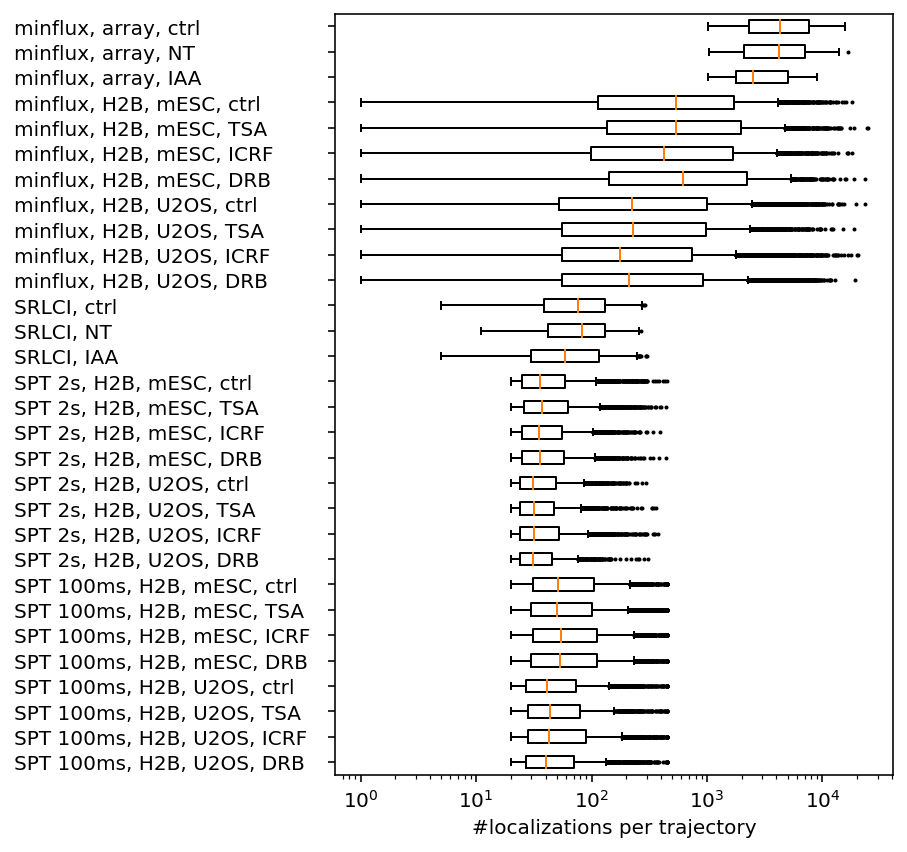

In [47]:
plt.figure(figsize=[5, 7])

labels = sorted(survival.keys())
plt.boxplot([survival[key] for key in labels], vert=False, flierprops=dict(marker='.', markersize=2))
plt.yticks(np.arange(len(survival))+1, labels, ha='left', x=-0.55)

plt.xscale('log')
plt.xlabel('#localizations per trajectory')
plt.show()

In [23]:
nl.io.write.hdf5({
    'trajectory_lengths' : survival,
    'description' : """
Survival data for minflux & Co.

'trajectory_lengths' is a dict with (hopefully) self-explanatory
keys; the entries are numpy arrays with valid data point counts
for each trajectory (sorted).

For plotting as survival curves.
"""[1:-1]}, '20250130_survival_curves.h5')